# Compare 2 files

In [1]:
import sys
import gc
import time
import numpy as np
import psutil
%matplotlib inline

import pandas as pd

%pylab inline
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import concurrent.futures 

from astropy.table import Table
from astropy.io import fits
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LogNorm
from decimal import *
from importlib import reload

from scipy.ndimage import zoom 
from mpl_toolkits.axes_grid.inset_locator import inset_axes


print('done')

Populating the interactive namespace from numpy and matplotlib
done


/home/brunohe/.local/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [2]:
#needed for reload
import procedures
reload (procedures)
#import without needing procedures.module
from procedures import *

import plots_input
reload (plots_input)
from plots_input import *

<br>

# 1 - Read Files

## 1.1 - Read if two files are not the same try to match

In [6]:
#RedshiftsToRead = [False,False,False,False,False,False,True,False]
#RedshiftsToRead = [False,False,False,False,True,False,False,False]
#RedshiftsToRead = [False,False,False,True,False,False,False,False]
#RedshiftsToRead = [True,False,False,False,False,False,False,False]
#RedshiftsToRead = [True,False, False,False,False,False,False,False,False,False]
RedshiftsToRead = [True, False, False, False,False,False,False,False,False,False,False,False]

FirstFile = 0
LastFile  = 0

#DirName_1 = '/scratch3/SAM/Henriques2019/Snaps/MR/'
#DirName_2 = '/scratch-ssd/SAM/test0/MR/'

#DirName_1 = '/scratch-ssd/SAM/test_tree_ori/MRII/'
DirName_1 = '/scratch-ssd/SAM/test_tree_0/MRII/'
DirName_2 = '/scratch-ssd/SAM/test_tree_1/MRII/'

#only snap output
print('\n** Reading 1st file **')
from LGalaxies_Henriques2019_Henriques2015_struct import LGalaxiesStruct
from LGalaxies_Henriques2019_Henriques2015_struct import PropertiesToRead
LGalaxiesStruct_1 = LGalaxiesStruct
PropertiesToRead_1 = PropertiesToRead
(G1, SnapshotList_MR) = read_snap(DirName_1,FirstFile,LastFile, PropertiesToRead_1,LGalaxiesStruct_1,
                                  RedshiftsToRead,FullRedshiftList)

print('\n\n\n\n** Reading 2nd file **')
from LGalaxies_Henriques2019_Henriques2015_struct import LGalaxiesStruct
from LGalaxies_Henriques2019_Henriques2015_struct import PropertiesToRead
LGalaxiesStruct_2 = LGalaxiesStruct
PropertiesToRead_2 = PropertiesToRead
(G2, SnapshotList_MR) = read_snap(DirName_2,FirstFile,LastFile, PropertiesToRead_2,LGalaxiesStruct_2,
                                  RedshiftsToRead,FullRedshiftList)
 
print("\n\nREADING DONE\n\n\n")    
'''#snap and tree output    
from LGalaxies_Henriques2016a_Elements_Rings_struct import LGalaxiesStruct
from LGalaxies_Henriques2016a_Elements_Rings_struct import PropertiesToRead
LGalaxiesStruct_1 = LGalaxiesStruct
PropertiesToRead_1 = PropertiesToRead
(G1, SnapshotList_1) = read_snap(DirName_MR,FirstFile,LastFile, PropertiesToRead_1,LGalaxiesStruct_1,
                                  RedshiftsToRead,FullRedshiftList)

    
from LGalaxies_tree_Henriques2016a_Elements_Rings_struct import LGalaxiesStruct
from LGalaxies_tree_Henriques2016a_Elements_Rings_struct import PropertiesToRead
LGalaxiesStruct_2 = LGalaxiesStruct
PropertiesToRead_2 = PropertiesToRead
(G2) = read_tree(DirName_MR,FirstFile,LastFile,PropertiesToRead_2,LGalaxiesStruct_2)
SnapshotList_2 = np.zeros(len(FullRedshiftList),dtype=np.int32)
G2 = G2[G2['SnapNum']==SnapshotList_1]'''

#select random elements of G1 to create G1_new
sel = (G1['StellarMass']>0.001) & (G1['Type']==2)
G1 = G1[sel]
N=5000
sel=np.random.rand(len(G1))<float(N/len(G1))
G1_new = G1[sel].copy()

#create empty G2_new
n_count = len(G1_new)
filter_list = []
props = PropertiesToRead_2
template = LGalaxiesStruct_2
for prop in props:
    if props[prop]:
        filter_list.append((prop,template[prop]))
filter_dtype = np.dtype(filter_list)    
G2_new = np.zeros(n_count,dtype=filter_dtype) 


print(f"Original Ngals: {len(G2)}, Selectedl Ngals: {len(G1_new)}")

#count number of matching galaxies based on Pos[0]
n_count = 0
n_double_counts=0
for nn in range(0, len(G1_new)):   
    if(nn%(int(len(G1_new)/10))==0):
        print(f"{int(nn/len(G1_new)*100)}%")
   
    #sel = G2['Mvir'] == G1['Mvir'][nn]
    sel = ((G2['Pos'][:,0] == G1_new['Pos'][nn,0]) &  
           (G2['Pos'][:,1] == G1_new['Pos'][nn,1]) &
           (G2['Pos'][:,2] == G1_new['Pos'][nn,2]))  
    if(sel.any()): 
        #if there is more than one gal with exactly the same position skip
        if(len(G2['Pos'][sel])>1):            
            n_double_counts+=1
            continue
        G2_new[nn] = G2[sel][0] 
        n_count+=1
    else:
        print('Non Match')
        print(G1_new[nn])
         #sel = G2['Mvir'] == G1['Mvir'][nn]
        sel = (((G2['Pos'][:,0] > G1_new['Pos'][nn,0]-1.) & (G2['Pos'][:,0] < G1_new['Pos'][nn,0]+1.)) &
               ((G2['Pos'][:,1] > G1_new['Pos'][nn,1]-1.) & (G2['Pos'][:,1] < G1_new['Pos'][nn,1]+1.)) &
               ((G2['Pos'][:,2] > G1_new['Pos'][nn,2]-1.) & (G2['Pos'][:,2] < G1_new['Pos'][nn,2]+1.)) )
        if(sel.any()): 
            print('found')
            print(G2[sel])
            print('done\n\n')
       
        
print(f"\n% of galaxies with exactly one match: {int((n_count)/(int(len(G1_new)))*100)}%")
print(f"\nGalaxies with more than 1 match: {n_double_counts}\n\n") 

G1 = G1_new
G2 = G2_new
print("reading done!")        


** Reading 1st file **


Reading Headers

z=0.00, nGals = 1558829



Reading redshift: 0.00

File 0  nGals = 1558829




** Reading 2nd file **


Reading Headers

z=0.00, nGals = 1558823



Reading redshift: 0.00

File 0  nGals = 1558823


READING DONE



Original Ngals: 1558823, Selectedl Ngals: 5073
0%
9%
19%
Non Match
(2, 27207697, 62, 6221.4814, 0.64432985, [-0.7110992 , -0.57526964, -0.5366447 ], [36.4265 , 54.99092, 89.44661], 27, 0.3283034, 0.00960939, 38.33185, 39.055935, 31, 0.00635769, 0.00138187, 1.7367487e-06, 0.00138014, 0., 0., 4.9900314e-07, 0., 9.556564e-06, 4.0435353e-07, 2.589086e-09, 4.0176445e-07, 0., 0., 1.591543e-06, 0.00078074, 0.00135918, 0.0013565, 0.00078464, 0.00078464, [-11.159607 , -12.059619 , -12.648964 , -12.947032 , -13.146456 , -13.221616 , -13.30095  , -13.3388815, -13.378171 , -12.977057 , -13.029107 , -12.171651 , -11.838088 , -11.204492 , -10.572635 , -11.05533  , -12.27976  , -12.864308 , -13.100916 , -13.234842 , -11.985287 , -12.292838 , -12.78

29%
39%
Non Match
(2, 17050632, 62, 7328.515, 0.6804804, [-0.2582678 , -0.15326117,  0.38341904], [45.345848, 90.86128 , 23.2639  ], 34, 1.5115885, 0.01424727, 67.5493, 64.767975, 29, 2.8060302e-05, 0.00221057, 0., 0.00221057, 0., 0., 1.9436845e-06, 0., 1.2352068e-08, 6.622698e-06, 0., 6.622698e-06, 0., 0., 0., 0.00055029, 0.00142473, 5.155974e-05, 0.00055466, 0.00055466, [-11.364342 , -12.365511 , -13.009477 , -13.336257 , -13.564931 , -13.666936 , -13.775421 , -13.821917 , -13.902723 , -13.520317 , -13.579751 , -12.725943 , -12.389231 , -11.740151 , -11.134795 , -11.260301 , -12.607522 , -13.245846 , -13.506584 , -13.684233 , -12.28373  , -12.622823 , -13.1593075, -13.272274 , -13.534334 , -13.5852165, -13.694483 ,  -3.0371418,  -8.684699 , -13.753077 , -13.891685 , -11.384591 , -13.768378 , -13.821537 , -13.898327 ,  -8.668813 ,  -9.516341 , -10.961483 , -10.229696 , -12.508419 ])
found
[(0, 1615329, 62, 1.8822037e-01, 0.02007702, [ 0.        ,  0.        ,  0.        ], [44.34866 ,

59%
Non Match
(2, 1000891, 62, 12718.28, 0.81774855, [ 1.2946109 ,  0.2036003 , -0.24930319], [94.465675 ,  6.8922048, 65.70045  ], 233, 4.276835, 0.03221858, 75.55757, 73.283394, 38, 0.00232441, 0.00748446, 0.00024826, 0.0072362, 0., 0., 3.4025802e-06, 0., 1.6111062e-05, 3.1425112e-05, 1.400105e-06, 3.0025009e-05, 0., 0., 0., 0.00045059, 0.00040049, 0.00026494, 0.00043483, 0.00043934, [-12.561544 , -13.605364 , -14.274587 , -14.613989 , -14.857868 , -14.969751 , -15.091363 , -15.14343  , -15.238173 , -14.864158 , -14.924912 , -14.075711 , -13.738307 , -13.084876 , -12.487308 , -12.458199 , -13.858484 , -14.5203   , -14.794743 , -14.988505 , -13.520443 , -13.874748 , -14.430824 , -14.547318 , -14.824795 , -14.880441 , -14.9992485,  -4.00153  ,  -9.764548 , -15.067176 , -15.224738 , -12.578427 , -15.083585 , -15.143093 , -15.229823 ,  -9.742452 , -10.641643 , -12.158365 , -11.39973  , -13.755686 ])
found
[(1, 1799193, 62, 0.14289525, 0.01831539, [ 0.04386139, -0.04660273, -0.00156403], 

89%
Non Match
(2, 1049148, 62, 13.373631, 0.08315597, [ 2.6671569e-05, -1.1797174e-04, -6.7865709e-05], [ 3.2142618,  5.2889905, 64.65432  ], 1776, 0.8642058, 0.01113957, 57.762276, 62.166527, 28, 0.01311943, 0.00950938, 3.678224e-05, 0.0094726, 0., 0., 1.0100145e-05, 0., 1.3767283e-05, 2.0236323e-05, 3.4451233e-08, 2.0201873e-05, 0., 0., 3.2041435e-06, 0.00224311, 0.00176356, 0.00175863, 0.0022319, 0.00218705, [-13.351152 , -14.301388 , -14.881583 , -15.174307 , -15.376555 , -15.46166  , -15.55466  , -15.594896 , -15.652767 , -15.264323 , -15.320778 , -14.448273 , -14.112689 , -13.470383 , -12.85273  , -13.241124 , -14.519812 , -15.092929 , -15.327386 , -15.476747 , -14.228629 , -14.532863 , -15.014575 , -15.117342 , -15.350762 , -15.393354 , -15.485401 ,  -7.5065193, -10.976967 , -15.535258 , -15.644975 , -13.37457  , -15.547941 , -15.594468 , -15.653269 , -10.973156 , -11.682015 , -12.946032 , -12.284833 , -14.429399 ])
found
[(0, 2560310, 62, 9.06554386e-02, 0.01573771, [ 0.0000000

99%

% of galaxies with exactly one match: 99%

Galaxies with more than 1 match: 0


reading done!


In [13]:
print(G1_new['Pos'][0:9,:])
print(G2_new['Pos'][0:9,:])

[[69.71187  14.894836 69.05617 ]
 [80.92477   8.138876 65.721565]
 [87.28455  15.657604 59.647728]
 [66.23287  16.472473 71.15407 ]
 [66.23365  16.428509 71.126   ]
 [66.83797  16.332087 70.80743 ]
 [66.83645  16.341526 70.81185 ]
 [61.986614 13.362047 62.799324]
 [61.900333 12.503806 62.195034]]
[[69.71187  14.894836 69.05617 ]
 [80.92477   8.138876 65.721565]
 [87.28455  15.657604 59.647728]
 [66.23287  16.472473 71.15407 ]
 [66.23365  16.428509 71.126   ]
 [66.83797  16.332087 70.80743 ]
 [66.83645  16.341526 70.81185 ]
 [61.986614 13.362047 62.799324]
 [61.900333 12.503806 62.195034]]


find missing haloes in tree file and SAM run on reorder tree

<br>

## 1.2 - Read files with same output same order

In [7]:
#RedshiftsToRead = [False,False,False,False,False,False,True,False]
#RedshiftsToRead = [False,False,False,False,True,False,False,False]
#RedshiftsToRead = [False,False,False,True,False,False,False,False]
#RedshiftsToRead = [True,False,False,False,False,False,False,False]
#RedshiftsToRead = [True,False, False,False,False,False,False,False,False,False]
RedshiftsToRead = [True, True, False,False,False,False,False,False,False,False,False,False]

DirName_1 = '/scratch-ssd/SAM/test2/MRII/'
DirName_2 = '/scratch-ssd/SAM/test3/MRII/'

FirstFile = 40
LastFile  = 40

#only snap output
from LGalaxies_Henriques2019_Elements_Rings_struct import LGalaxiesStruct
from LGalaxies_Henriques2019_Elements_Rings_struct import PropertiesToRead
(G1, SnapshotList_MR) = read_snap(DirName_1,FirstFile,LastFile,
                                    PropertiesToRead,LGalaxiesStruct,RedshiftsToRead,FullRedshiftList)
(G2, SnapshotList_MR) = read_snap(DirName_2,FirstFile,LastFile,
                                    PropertiesToRead,LGalaxiesStruct,RedshiftsToRead,FullRedshiftList)

'''
#snap and tree output    
from LGalaxies_Henriques2019_Elements_Rings_struct import LGalaxiesStruct
from LGalaxies_Henriques2019_Elements_Rings_struct import PropertiesToRead
  
(G1, SnapshotList_1) = read_snap(DirName_MR,FirstFile,LastFile, PropertiesToRead,LGalaxiesStruct,
                                  RedshiftsToRead,FullRedshiftList)
print(SnapshotList_1) 
    
from LGalaxies_tree_Henriques2019_Elements_Rings_struct import LGalaxiesStruct
from LGalaxies_tree_Henriques2019_Elements_Rings_struct import PropertiesToRead
  
(G2) = read_tree(DirName_MR,FirstFile,LastFile,PropertiesToRead,LGalaxiesStruct)
SnapshotList_2 = np.zeros(len(FullRedshiftList),dtype=np.int32)
G2 = G2[G2['SnapNum']==SnapshotList_1]'''

print(len(G1))
print(len(G2))

if(len(G1)>len(G2)):
    G1=G1[0:len(G2)]
else:    
    G2=G2[0:len(G1)]

print(len(G1), len(G2))

ModuleNotFoundError: No module named 'LGalaxies_Henriques2019_Elements_Rings_struct'

<br>

# 2 - Plots

## 2.1 - Plots without rings to compare two files

In [9]:
sel = G1['StellarMass']>0.001

#N=2000
#sel=np.random.rand(len(G1))<float(N/len(G1))
G1_rand=G1[sel]
G2_rand=G2[sel]

print(len(G1_rand))

with PdfPages('./fig/plots.pdf') as pdf:  
       
        
    #SCATTER PLOTS of ORIGINAL vs CUT    
    fig = plt.figure(figsize=(15,15))
    grid = gridspec.GridSpec(5, 2)
    grid.update(wspace=0.2, hspace=0.3)    
    
    properties = ['Mvir', 'Rvir', 'EjectedMass', 'HotGas', 'MetalsEjectedMass', 'MetalsHotGas', 
                  'ColdGas', 'StellarMass', 'StellarHalfMassRadius', 'Pos']
    
    for idx, prop in enumerate(properties):
        if('Metals' in prop):
            xlim=[-5.0,2.]
            ylim=[-5.0,2.]    
        elif('Mvir' in prop):    
            xlim=[0.0,5.]
            ylim=[0.0,5.] 
        elif('Rvir' in prop):    
            xlim=[-2.0,1.]
            ylim=[-2.0,1.]
        elif('Radius' in prop):    
            xlim=[-4.0,-1.]
            ylim=[-4.0,-1.]    
        else:
            xlim=[-5.0,5.]
            ylim=[-5.0,5.]    
        subplot=plt.subplot(grid[idx])
        subplot.set_ylim(ylim), subplot.set_xlim(xlim)  
        subplot.set_xlabel(prop+' CUT'), subplot.set_ylabel(prop+' ORIGINAL')
        if(prop=='Pos'):
            plt.scatter(np.log10(G1_rand['Pos'][:,0]),np.log10(G2_rand['Pos'][:,0]),s=2,color='black')
        else:
            plt.scatter(np.log10(G1_rand[prop]),np.log10(G2_rand[prop]),s=2,color='black')
    
    pdf.savefig()
    plt.close()
    
    
    #HISTOGRAMS of ORIGINAL/CUT
    fig = plt.figure(figsize=(15,15))
    grid = gridspec.GridSpec(5, 2)
    grid.update(wspace=0.2, hspace=0.4)    
    
    outliers_lim = 0.000001
    xlim=[-1.0,1.]
    ylim=[0.0,1.0]    
    
    properties = ['Mvir', 'Rvir', 'EjectedMass', 'HotGas', 'MetalsEjectedMass', 'MetalsHotGas', 
                  'ColdGas', 'StellarMass', 'StellarHalfMassRadius']
    
    for idx, prop in enumerate(properties):
        subplot=plt.subplot(grid[idx])
        subplot.set_ylim(ylim), subplot.set_xlim(xlim)       
        plt.hist(1.-G1_rand[prop]/G2_rand[prop], weights=np.ones(len(G1_rand))/len(G1_rand),
                 density=False, bins=np.arange(-1.,1.,0.1))
        subplot.set_xlabel('1-ORIGINAL/CUT ('+prop+')' ), subplot.set_ylabel('fraction')
        
        sel = ((1.-G1_rand[prop]/G2_rand[prop]<-outliers_lim) | 
               (1.-G1_rand[prop]/G2_rand[prop]>outliers_lim))
        f_outliers = int(len(G1_rand[prop][sel])/len(G1_rand[prop])*100)    
        plt.text(-0.9,0.2, f"% of outliers: {f_outliers}%")
        
    subplot=plt.subplot(grid[idx])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)       
    plt.hist(1.-G1_rand['Pos'][:,0]/G2_rand['Pos'][:,0], weights=np.ones(len(G1_rand))/len(G1_rand),
             density=False, bins=np.arange(-1.,1.,0.1))
    subplot.set_xlabel('1-ORIGINAL/CUT ('+prop+')' ), subplot.set_ylabel('fraction')

    sel = ((1.-G1_rand['Pos'][:,0]/G2_rand['Pos'][:,0]<-outliers_lim) | 
           (1.-G1_rand['Pos'][:,0]/G2_rand['Pos'][:,0]>outliers_lim))
    f_outliers = int(len(G1_rand['Pos'][sel,0])/len(G1_rand['Pos'][:,0])*100)    
    plt.text(-0.9,0.2, f"% of outliers: {f_outliers}%")
       
    pdf.savefig()
    plt.close()
    
    
    print("All Plots Done!")

5073


/usr/lib/python3/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in less
/usr/lib/python3/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in 

All Plots Done!


<br>

## 2.2 - Plots with rings to compare two files

ValueError: no field of name HotGas_elements

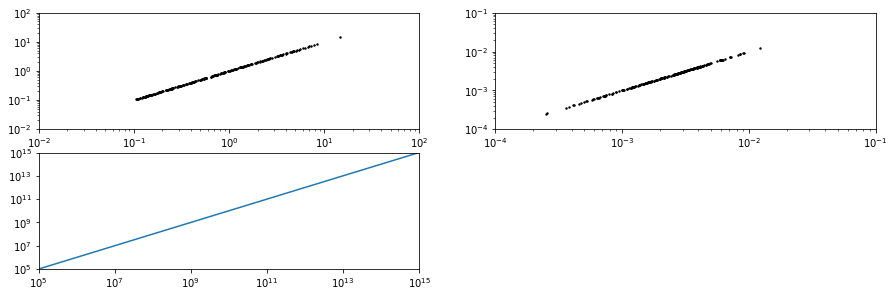

In [9]:
sel = G1['StellarMass']>0.1

#N=2000
#sel=np.random.rand(len(G1))<float(N/len(G1))
G1_rand=G1[sel]
G2_rand=G2[sel]


with PdfPages('./fig/plots.pdf') as pdf:  
   
    fig = plt.figure(figsize=(15,15))
    grid = gridspec.GridSpec(6, 2)
    
    xlim=[0.01,100.]
    ylim=[0.01,100.]    
    subplot=plt.subplot(grid[0])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)   
    subplot.set_xscale("log")
    subplot.set_yscale("log")
    plt.scatter(G1_rand['StellarMass'],G2_rand['StellarMass'],s=2,color='black')
    
    xlim=[0.0001,0.1]
    ylim=[0.0001,0.1]    
    subplot=plt.subplot(grid[1])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)   
    subplot.set_xscale("log")
    subplot.set_yscale("log")
    plt.scatter(G1_rand['StellarHalfMassRadius'],G2_rand['StellarHalfMassRadius'],s=2,color='black')
   
    '''xlim=[0.1,1e12]
    ylim=[0.1,1e12]      
    subplot=plt.subplot(grid[1])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    plt.scatter(G1_rand['DiskMass_elements'][:,0],G2_rand['DiskMass_elements'][:,0],s=2,color='black')
    
    subplot=plt.subplot(grid[2])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    plt.scatter(G1_rand['DiskMass_elements'][:,5],G2_rand['DiskMass_elements'][:,5],s=2,color='black')'''
    
    '''xlim=[0.1,1e15]
    ylim=[0.1,1e15]
    subplot=plt.subplot(grid[0])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    plt.scatter(G1_rand['HotGas_elements'][:,0],G2_rand['HotGas_elements'][:,0],s=2,color='black')
    
    subplot=plt.subplot(grid[1])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    plt.scatter(G1_rand['HotGas_elements'][:,5],G2_rand['HotGas_elements'][:,5],s=2,color='black')'''
    
    '''xlim=[0.1,1e12]
    ylim=[0.1,1e12]      
    subplot=plt.subplot(grid[0])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    plt.scatter(G1_rand['sfh_ElementsDiskMass'][:,0,0],G2_rand['sfh_ElementsDiskMass'][:,0,0],s=2,color='black')
    
    subplot=plt.subplot(grid[1])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    plt.scatter(G1_rand['sfh_ElementsDiskMass'][:,5,5],G2_rand['sfh_ElementsDiskMass'][:,5,5],s=2,color='black')'''
    
    xlim=[1e5,1e15]
    ylim=[1e5,1e15]
    subplot=plt.subplot(grid[2])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    subplot.scatter(G1_rand['HotGas_elements'][:,0],G2_rand['HotGas_elements'][:,0],s=2,color='black')
    
    xlim=[1e2,1e15]
    ylim=[1e2,1e15]
    subplot=plt.subplot(grid[3])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    subplot.scatter(G1_rand['HotGas_elements'][:,2],G2_rand['HotGas_elements'][:,2],s=2,color='black')
        
    #print("HOT GAS")
    sel=(G1_rand['HotGas_elements'][:,0]!=G2_rand['HotGas_elements'][:,0])
    #print(G1_rand['HaloIndex'][sel])
    #print(G2_rand['HaloIndex'][sel])
    #print(G1_rand['HotGas_elements'][sel,0]/G2_rand['HotGas_elements'][sel,0])    
    #print("")
    
    
    
    xlim=[0.1,1e12]
    ylim=[0.1,1e12]
    subplot=plt.subplot(grid[4])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    subplot.scatter(G1_rand['ColdGas_elements'][:,0],G2_rand['ColdGas_elements'][:,0],s=2,color='black')

    
    subplot=plt.subplot(grid[5])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    subplot.plot(x,y)
    plt.scatter(G1_rand['ColdGas_elements'][:,5],G2_rand['ColdGas_elements'][:,5],s=2,color='black')
  
    subplot=plt.subplot(grid[6])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    subplot.plot(x,y)
    plt.scatter(G1_rand['DiskMass_elements'][:,0],G2_rand['DiskMass_elements'][:,0],s=2,color='black')

    subplot=plt.subplot(grid[7])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")
    subplot.plot(x,y)
    plt.scatter(G1_rand['DiskMass_elements'][:,5],G2_rand['DiskMass_elements'][:,5],s=2,color='black')
    
    '''xlim=[0.1,1e12]
    ylim=[0.1,1e12]      
    subplot=plt.subplot(grid[5])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    plt.scatter(G1_rand['sfh_ElementsDiskMass'][:,0,0],G2_rand['sfh_ElementsDiskMass'][:,0,0],s=2,color='black')
    
    subplot=plt.subplot(grid[6])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    plt.scatter(G1_rand['sfh_ElementsDiskMass'][:,5,5],G2_rand['sfh_ElementsDiskMass'][:,5,5],s=2,color='black')'''
    
    xlim=[0.00001,1e4]
    ylim=[0.00001,1e4]   
    subplot=plt.subplot(grid[8])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    plt.scatter(G1_rand['MetalsColdGas'][:,0],G2_rand['MetalsColdGas'][:,0],s=2,color='black')
    
    
    
    xlim=[0.0000001,1e4]
    ylim=[0.0000001,1e4]
    subplot=plt.subplot(grid[9])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    plt.scatter(G1_rand['MetalsColdGas'][:,1],G2_rand['MetalsColdGas'][:,1],s=2,color='black')
    
    sel=(G1_rand['MetalsColdGas'][:,0]!=G2_rand['MetalsColdGas'][:,0])
    #print(G1_rand['HaloIndex'][sel])
    #print(G2_rand['HaloIndex'][sel])
    #print(G1_rand['ColdGas_elements'][sel,0]/G2_rand['ColdGas_elements'][sel,0])
        
    '''xlim=[0.1,1e12]
    ylim=[0.1,1e12]   
    subplot=plt.subplot(grid[4])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    plt.scatter(G1_rand['ColdGasRings_elements'][:,0,0],G2_rand['ColdGasRings_elements'][:,0,0],s=2,color='black')
    
    
    
    xlim=[0.0000001,1e12]
    ylim=[0.0000001,1e12]
    subplot=plt.subplot(grid[5])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    plt.scatter(G1_rand['ColdGasRings_elements'][:,2,5],G2_rand['ColdGasRings_elements'][:,2,5],s=2,color='black')'''
    
    xlim=[0.1,1e12]
    ylim=[0.1,1e12]      
    subplot=plt.subplot(grid[10])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")  
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    plt.scatter(G1_rand['DiskMassRings_elements'][:,0,0],G2_rand['DiskMassRings_elements'][:,0,0],s=2,color='black')
    
    xlim=[0.0000001,1e12]
    ylim=[0.0000001,1e12] 
    subplot=plt.subplot(grid[11])
    subplot.set_ylim(ylim), subplot.set_xlim(xlim)    
    subplot.set_xscale("log")
    subplot.set_yscale("log")
    x=np.arange(xlim[0],xlim[1],(xlim[1]-xlim[0])/100.)
    y=x
    subplot.plot(x,y)
    plt.scatter(G1_rand['DiskMassRings_elements'][:,10,0],G2_rand['DiskMassRings_elements'][:,10,0],s=2,color='black')
        
   
    
    
    pdf.savefig()
    plt.close()
    
    
   

    
    print("All Plots Done!")

<br>

# 3 - Read Halo IDS and Additional Matchs for very different files

In [4]:
DirName_MR = '/scratch-ssd/Millennium2/BigRun/modified_trees/treedata/'   
    
from struct_tree_MR import LGalaxiesStruct as LGalaxiesStruct_1
from struct_tree_MR import PropertiesToRead as PropertiesToRead_1  
from struct_tree_dbids_MRII import LGalaxiesStruct as LGalaxiesStruct_2
from struct_tree_dbids_MRII import PropertiesToRead as PropertiesToRead_2  

SIM_Prefix='sf1_'
SIM_LastSnap='067'
(G_Halo_1, G_Halo_IDS_1) = read_halo_tree(DirName_MR, SIM_Prefix, SIM_LastSnap, FirstFile, LastFile,
                                      PropertiesToRead_1, LGalaxiesStruct_1, 
                                      PropertiesToRead_2, LGalaxiesStruct_2) 

print('reading done')



Reading Headers For Halo File

TotNHalos= 91130412


Reading File 0, nHalos = 91130412

reading of halos done


reading done


In [19]:
pos = [15.447242, 70.94498 , 94.46597 ]
print(f'original pos: {pos}')
sc_pos = 0.960558
p_lim = 0.00001
sel = ((G_Halo_1['Pos'][:,0] > pos[0]/sc_pos-p_lim) & (G_Halo_1['Pos'][:,0] < pos[0]/sc_pos+p_lim) &
       (G_Halo_1['Pos'][:,1] > pos[1]/sc_pos-p_lim) & (G_Halo_1['Pos'][:,1] < pos[1]/sc_pos+p_lim) &
       (G_Halo_1['Pos'][:,2] > pos[2]/sc_pos-p_lim) & (G_Halo_1['Pos'][:,2] < pos[2]/sc_pos+p_lim))

print('\n\nmatch in tree file')
print(G_Halo_1['Pos'][sel,:]*sc_pos)
print(G_Halo_IDS_1[sel])

sel = ((G2['Pos'][:,0] > pos[0]-0.1) & (G2['Pos'][:,0] < pos[0]+0.1) &
       (G2['Pos'][:,1] > pos[1]-0.1) & (G2['Pos'][:,1] < pos[1]+0.1) &
       (G2['Pos'][:,2] > pos[2]-0.1) & (G2['Pos'][:,2] < pos[2]+0.1))
print('\n\nmatch in SAM run on reorder tree')
print(G2['Pos'][sel,:])

print('done')

original pos: [15.447242, 70.94498, 94.46597]


match in tree file
[[15.447242 70.94498  94.46597 ]]
[(0, 0, 0., 0., [0., 0., 0.], 0, 1000014996, 1000000000, 1000014997, 1000016070, -1, 1000014995, 1000014996, 1000016398, -5448.711)]


match in SAM run on reorder tree
[]
done


# 4 - Old read, twice as slower but creates new galaxy structure only with exact matches (better if files differ a lot)

In [20]:
#RedshiftsToRead = [False,False,False,False,False,False,True,False]
#RedshiftsToRead = [False,False,False,False,True,False,False,False]
#RedshiftsToRead = [False,False,False,True,False,False,False,False]
#RedshiftsToRead = [True,False,False,False,False,False,False,False]
#RedshiftsToRead = [True,False, False,False,False,False,False,False,False,False]
RedshiftsToRead = [True, False, False, False,False,False,False,False,False,False,False,False]

FirstFile = 1
LastFile  = 1

#DirName_1 = '/scratch3/SAM/Henriques2019/Snaps/MR/'
#DirName_2 = '/scratch-ssd/SAM/test0/MR/'

DirName_1 = '/scratch-ssd/SAM/test_tree_ori/MRII/'
DirName_2 = '/scratch-ssd/SAM/test_tree_0/MRII/'

#only snap output
print('\n** Reading 1st file **')
from LGalaxies_Henriques2019_Henriques2015_struct import LGalaxiesStruct
from LGalaxies_Henriques2019_Henriques2015_struct import PropertiesToRead
LGalaxiesStruct_1 = LGalaxiesStruct
PropertiesToRead_1 = PropertiesToRead
(G1, SnapshotList_MR) = read_snap(DirName_1,FirstFile,LastFile, PropertiesToRead_1,LGalaxiesStruct_1,
                                  RedshiftsToRead,FullRedshiftList)

print('\n\n\n\n** Reading 2nd file **')
from LGalaxies_Henriques2019_Henriques2015_struct import LGalaxiesStruct
from LGalaxies_Henriques2019_Henriques2015_struct import PropertiesToRead
LGalaxiesStruct_2 = LGalaxiesStruct
PropertiesToRead_2 = PropertiesToRead
(G2, SnapshotList_MR) = read_snap(DirName_2,FirstFile,LastFile, PropertiesToRead_2,LGalaxiesStruct_2,
                                  RedshiftsToRead,FullRedshiftList)
 
print("\n\nREADING DONE\n\n\n")    
'''#snap and tree output    
from LGalaxies_Henriques2016a_Elements_Rings_struct import LGalaxiesStruct
from LGalaxies_Henriques2016a_Elements_Rings_struct import PropertiesToRead
LGalaxiesStruct_1 = LGalaxiesStruct
PropertiesToRead_1 = PropertiesToRead
(G1, SnapshotList_1) = read_snap(DirName_MR,FirstFile,LastFile, PropertiesToRead_1,LGalaxiesStruct_1,
                                  RedshiftsToRead,FullRedshiftList)

    
from LGalaxies_tree_Henriques2016a_Elements_Rings_struct import LGalaxiesStruct
from LGalaxies_tree_Henriques2016a_Elements_Rings_struct import PropertiesToRead
LGalaxiesStruct_2 = LGalaxiesStruct
PropertiesToRead_2 = PropertiesToRead
(G2) = read_tree(DirName_MR,FirstFile,LastFile,PropertiesToRead_2,LGalaxiesStruct_2)
SnapshotList_2 = np.zeros(len(FullRedshiftList),dtype=np.int32)
G2 = G2[G2['SnapNum']==SnapshotList_1]'''

sel = (G1['StellarMass']>0.001) & (G1['Type']<2)
G1 = G1[sel]
N=10000
sel=np.random.rand(len(G1))<float(N/len(G1))
G1 = G1[sel]
#G1 = G1[:int(len(G1)/100)]
#G2 = G2[:int(len(G2)/20)]

print(f"Original Ngals: {len(G2)}, Selectedl Ngals: {len(G1)}")

#count number of matching galaxies based on Pos[0]
n_count = 0
n_double_counts=0
for nn in range(0, len(G1)):   
    if(nn%(int(len(G1)/10))==0):
        print(f"{int(nn/len(G1)*100)}%")
   
    #sel = G2['Mvir'] == G1['Mvir'][nn]
    sel = ((G2['Pos'][:,0] == G1['Pos'][nn,0]) &  
           (G2['Pos'][:,1] == G1['Pos'][nn,1]) &
           (G2['Pos'][:,2] == G1['Pos'][nn,2]))  
    if(sel.any()): 
        #if there is more than one gal with exactly the same position skip
        if(len(G2['Pos'][sel])>1):
            n_double_counts+=1
            continue
        n_count+=1
    else:
        print('Non Match')
        print(G1[nn])
         #sel = G2['Mvir'] == G1['Mvir'][nn]
        sel = (((G2['Pos'][:,0] > G1['Pos'][nn,0]-1.) & (G2['Pos'][:,0] < G1['Pos'][nn,0]+1.)) &
               ((G2['Pos'][:,1] > G1['Pos'][nn,1]-1.) & (G2['Pos'][:,1] < G1['Pos'][nn,1]+1.)) &
               ((G2['Pos'][:,2] > G1['Pos'][nn,2]-1.) & (G2['Pos'][:,2] < G1['Pos'][nn,2]+1.)) )
        if(sel.any()): 
            print('found')
            print(G2[sel])
            print('done\n\n')
       
        
print(f"\n% of galaxies with exactly one match: {int((n_count)/(int(len(G1)))*100)}%")
print(f"\nGalaxies with more than 1 match: {n_double_counts}\n\n") 

#create new structures
filter_list = []
props = PropertiesToRead_1
template = LGalaxiesStruct_1
for prop in props:
    if props[prop]:
        filter_list.append((prop,template[prop]))
filter_dtype = np.dtype(filter_list)    
new_G1 = np.zeros(n_count,dtype=filter_dtype) 

#create new structures
filter_list = []
props = PropertiesToRead_2
template = LGalaxiesStruct_2
for prop in props:
    if props[prop]:
        filter_list.append((prop,template[prop]))
filter_dtype = np.dtype(filter_list)    
new_G2 = np.zeros(n_count,dtype=filter_dtype) 

index = 0
for nn in range(0, len(G1)):
    if(nn%(int(len(G1)/10))==0):
        print(f"{int(nn/len(G1)*100)}%")
    #sel = (G2['Mvir'] == G1['Mvir'][nn])   
    sel = ((G2['Pos'][:,0] == G1['Pos'][nn,0]) &  
           (G2['Pos'][:,1] == G1['Pos'][nn,1]) &
           (G2['Pos'][:,2] == G1['Pos'][nn,2]))  
    if(sel.any()):  
        #if there is more than one gal with exactly the same position skip
        if(len(G2['StellarMass'][sel])>1):
            continue
            #print(G2['Pos'][sel,0][0],G2['StellarMass'][sel][0],G1['Pos'][nn,0],G1['StellarMass'][nn])
        new_G2[index] = G2[sel][0]         
        new_G1[index] = G1[nn]
        index+=1

G1 = new_G1
G2 = new_G2
print("reading done!")
        


** Reading 1st file **


Reading Headers

z=0.00, nGals = 305979



Reading redshift: 0.00

File 1  nGals = 305979




** Reading 2nd file **


Reading Headers

z=0.00, nGals = 305978



Reading redshift: 0.00

File 1  nGals = 305978


READING DONE



11407
Original Ngals: 305978, Selectedl Ngals: 9945
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[0 1 2 2 2 2 2 2 0 2 2 2 0 0 2 2 2 0 0 1]
0%
9%
19%
29%
39%
49%
59%
69%
79%
89%
99%

% of galaxies with exactly one match: 100%

Galaxies with more than 1 match: 0


0%
9%
19%
29%
39%
49%
59%
69%
79%
89%
99%
reading done!
